In [1]:
import os
import sys
from matplotlib import rcParams
import numpy as np

from ai.new_zonotope import HybridZonotope
import torch
import matplotlib.pyplot as plt
import time

In [2]:
# font = {'family' : 'normal',
#         'size'   : 14}
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Palatio']
rcParams['text.usetex'] = True

fontsize = 18 #adjust

#plt.rc('font', **font)
# figure_path = "../../smoothing-ensemble-paper/figure_archive/"

In [3]:
def step(x, A):
    h = (-1*x*x*A)+1
    x = x + x * (0.5 * h + 0.375 * h * h)
    return x

In [4]:
def check(x, A, eps):
    lb_res, ub_res = (x*x - A.concretize_into_box().reciprocal()).concretize()
    return ub_res > - eps if lb_res<0 else lb_res <= eps

In [5]:
dtype = torch.float64

## Householder's Method [16,20]

In [6]:
A_rng = [16, 20]
x0 = 2**(-3)
eps = 1e-6

In [7]:
A = A_rng[0]
x = x0

lb_e = [1/x0]

for i in range(50):
    x = step(x, A)
    lb_e.append(1/x)

A = A_rng[1]
x = x0

ub_e = [x0]

for i in range(50):
    x = step(x, A)
    ub_e.append(1/x)

In [8]:
### CRAFT for Householder
torch.set_printoptions(precision=8)

x = HybridZonotope.construct_from_bounds(torch.tensor([[x0]]), torch.tensor([[x0]]), domain='zono', dtype=dtype)
A = HybridZonotope.construct_from_bounds(torch.tensor([[A_rng[0]]]), torch.tensor([[A_rng[1]]]), domain='zono', dtype=dtype)

lbs, ubs = [1/x.concretize()[0].item()], [1/x.concretize()[1].item()]

print(f"Input range [{A.concretize()[0].item():.2f}, {A.concretize()[1].item():.2f}]")

print(f"Init range [{1/x.concretize()[0].item():.2f}, {1/x.concretize()[1].item():.2f}]")


for i in range(50):
    xnew = step(x, A)
    lb, ub = xnew.concretize()
    root = x.concretize_into_box()#.reciprocal()
    lbs.append(1/xnew.concretize()[0].item())
    ubs.append(1/xnew.concretize()[1].item())
    root_new = xnew.concretize_into_box()#.reciprocal()
    print(f"root{i+1}", xnew.concretize_into_box().reciprocal().concretize())
    cont, _ = root.can_contain(root_new)
    if cont:
        print(x.concretize())
        print(xnew.concretize())
        print(f"x{i+1} in x{i} -> break" )
        break
    x = xnew

lb_craft = lbs
ub_craft = ubs

Input range [16.00, 20.00]
Init range [8.00, 8.00]
root1 (tensor([[5.04433537]]), tensor([[5.26097775]]))
root2 (tensor([[4.07547569]]), tensor([[4.52015209]]))
root3 (tensor([[3.98864937]]), tensor([[4.49312496]]))
root4 (tensor([[3.98410249]]), tensor([[4.49316978]]))
root5 (tensor([[3.98345995]]), tensor([[4.49320841]]))
root6 (tensor([[3.98336363]]), tensor([[4.49321413]]))
root7 (tensor([[3.98334980]]), tensor([[4.49321461]]))
root8 (tensor([[3.98334765]]), tensor([[4.49321461]]))
root9 (tensor([[3.98334694]]), tensor([[4.49321461]]))
root10 (tensor([[3.98334694]]), tensor([[4.49321461]]))
(tensor([[0.22255779]], dtype=torch.float64), tensor([[0.25104515]], dtype=torch.float64))
(tensor([[0.22255779]], dtype=torch.float64), tensor([[0.25104516]], dtype=torch.float64))
x10 in x9 -> break


In [9]:
### Kleene for Householder

torch.set_printoptions(precision=8)

x = HybridZonotope.construct_from_bounds(torch.tensor([[x0]]), torch.tensor([[x0]]), domain='zono', dtype=dtype)
A = HybridZonotope.construct_from_bounds(torch.tensor([[A_rng[0]]]), torch.tensor([[A_rng[1]]]), domain='zono', dtype=dtype)

lbs, ubs = [1/x.concretize()[0].item()], [1/x.concretize()[1].item()]

unrolling = True
n_unrolling = 0

for i in range(50):
    z = x
    z = step(z, A)
    c = check(x, A, eps).item()
    if i>=n_unrolling and (not unrolling or c):
        xnew = x.join(z)
        unrolling = False
        joined = True
    else:
        xnew=z
        joined = False
    lb, ub = xnew.concretize()
    root = x.concretize_into_box()#.reciprocal()
    lbs.append(1/xnew.concretize()[0].item())
    ubs.append(1/xnew.concretize()[1].item())
    root_new = xnew.concretize_into_box()#.reciprocal()
    print(f"joined: {joined}, check: {c}, root{i+1}:", xnew.concretize_into_box().reciprocal().concretize())
    cont, _ = root.can_contain(root_new)
    if cont:
        print(x.concretize())
        print(xnew.concretize())
        print(f"x{i+1} in x{i} -> break" )
        break
    x = xnew

lb_kleene = lbs
ub_kleene = ubs

joined: False, check: False, root1: (tensor([[5.04433537]]), tensor([[5.26097775]]))
joined: False, check: False, root2: (tensor([[4.07547569]]), tensor([[4.52015209]]))
joined: True, check: True, root3: (tensor([[3.98864937]]), tensor([[4.52015209]]))
joined: True, check: True, root4: (tensor([[3.87006664]]), tensor([[4.52015209]]))
joined: True, check: True, root5: (tensor([[3.81439662]]), tensor([[4.52015209]]))
joined: True, check: True, root6: (tensor([[3.78435993]]), tensor([[4.52015209]]))
joined: True, check: True, root7: (tensor([[3.76688099]]), tensor([[4.52015209]]))
joined: True, check: True, root8: (tensor([[3.75627589]]), tensor([[4.52015209]]))
joined: True, check: True, root9: (tensor([[3.74967957]]), tensor([[4.52015209]]))
joined: True, check: True, root10: (tensor([[3.74551487]]), tensor([[4.52015209]]))
joined: True, check: True, root11: (tensor([[3.74286008]]), tensor([[4.52015209]]))
joined: True, check: True, root12: (tensor([[3.74115825]]), tensor([[4.52015209]]

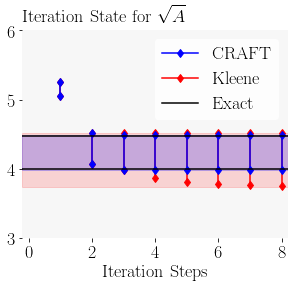

In [10]:
fig, ax = plt.subplots(figsize=(4.2,4))

marker = "d"

for i in range(len(ub_craft)):
    if i>0:
        plt.plot([i,i],[lb_kleene[i], ub_kleene[i]],f"-{marker}", color="r", label='_nolegend_')
        plt.plot([i,i],[lb_craft[i], ub_craft[i]],f"-{marker}", color="b", label='_nolegend_')
    else:
        plt.plot([i,i],[lb_craft[i], ub_craft[i]],f"-{marker}", color="b")
        plt.plot([i,i],[lb_kleene[i], ub_kleene[i]],f"-{marker}", color="r")

plt.fill([-0.2, len(ub_craft)+0.2, len(ub_craft)+0.2, -0.2], [lb_kleene[-1],lb_kleene[-1],ub_kleene[-1],ub_kleene[-1]], color="r", alpha=0.15)
plt.fill([-0.2, len(ub_craft)+0.2, len(ub_craft)+0.2, -0.2], [lb_craft[-1],lb_craft[-1],ub_craft[-1],ub_craft[-1]], color="b", alpha=0.2)
plt.plot([-0.2, len(ub_craft)+0.2], [lb_e[-1],lb_e[-1]], color="k")
plt.plot([len(ub_craft)+0.2, -0.2], [ub_e[-1],ub_e[-1]], color="k")


plt.ylabel(r"Iteration State for $\sqrt{A}$",rotation=0 , fontsize=fontsize, ha="left")
ax.yaxis.set_label_coords(0.0, 1.03)
plt.xlabel("Iteration Steps", fontsize=fontsize)
plt.xlim([-0.2,8+0.2])
plt.xticks(np.arange(0,10,2))
plt.ylim([3,6])
plt.yticks(np.arange(3.,6.01,1))
plt.legend(["CRAFT", "Kleene", "Exact"], frameon=True, edgecolor="none", fontsize=fontsize)

ax.set_facecolor( (0.97, 0.97, 0.97) )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.tight_layout()

## Householder's Method [16,25]

In [11]:
A_rng = [16, 25]
x0 = 2**(-3)
eps = 1e-6

In [12]:
A = A_rng[0]
x = x0

lb_e = [1/x0]

for i in range(50):
    x = step(x, A)
    lb_e.append(1/x)

A = A_rng[1]
x = x0

ub_e = [x0]

for i in range(50):
    x = step(x, A)
    ub_e.append(1/x)

In [13]:
### CRAFT for Householder
torch.set_printoptions(precision=8)

x = HybridZonotope.construct_from_bounds(torch.tensor([[x0]]), torch.tensor([[x0]]), domain='zono', dtype=dtype)
A = HybridZonotope.construct_from_bounds(torch.tensor([[A_rng[0]]]), torch.tensor([[A_rng[1]]]), domain='zono', dtype=dtype)

lbs, ubs = [1/x.concretize()[0].item()], [1/x.concretize()[1].item()]

print(f"Input range [{A.concretize()[0].item():.2f}, {A.concretize()[1].item():.2f}]")

print(f"Init range [{1/x.concretize()[0].item():.2f}, {1/x.concretize()[1].item():.2f}]")


for i in range(50):
    xnew = step(x, A)
    lb, ub = xnew.concretize()
    root = x.concretize_into_box()#.reciprocal()
    lbs.append(1/xnew.concretize()[0].item())
    ubs.append(1/xnew.concretize()[1].item())
    root_new = xnew.concretize_into_box()#.reciprocal()
    print(f"root{i+1}", xnew.concretize_into_box().reciprocal().concretize())
    cont, _ = root.can_contain(root_new)
    if cont:
        print(x.concretize())
        print(xnew.concretize())
        print(f"x{i+1} in x{i} -> break" )
        break
    x = xnew

lb_craft = lbs
ub_craft = ubs

Input range [16.00, 25.00]
Init range [8.00, 8.00]
root1 (tensor([[5.04433489]]), tensor([[5.54752207]]))
root2 (tensor([[4.06878376]]), tensor([[5.08317471]]))
root3 (tensor([[3.94174027]]), tensor([[5.09716415]]))
root4 (tensor([[3.90973854]]), tensor([[5.10059547]]))
root5 (tensor([[3.89670038]]), tensor([[5.10262728]]))
root6 (tensor([[3.89103651]]), tensor([[5.10345602]]))
root7 (tensor([[3.88853383]]), tensor([[5.10381985]]))
root8 (tensor([[3.88742137]]), tensor([[5.10398197]]))
root9 (tensor([[3.88692379]]), tensor([[5.10405350]]))
root10 (tensor([[3.88670230]]), tensor([[5.10408497]]))
root11 (tensor([[3.88660288]]), tensor([[5.10409975]]))
root12 (tensor([[3.88655901]]), tensor([[5.10410643]]))
root13 (tensor([[3.88653898]]), tensor([[5.10410929]]))
root14 (tensor([[3.88653040]]), tensor([[5.10411024]]))
root15 (tensor([[3.88652587]]), tensor([[5.10411072]]))
root16 (tensor([[3.88652396]]), tensor([[5.10411072]]))
root17 (tensor([[3.88652325]]), tensor([[5.10411167]]))
root18

In [14]:
### Kleene for Householder

torch.set_printoptions(precision=8)

x = HybridZonotope.construct_from_bounds(torch.tensor([[x0]]), torch.tensor([[x0]]), domain='zono', dtype=dtype)
A = HybridZonotope.construct_from_bounds(torch.tensor([[A_rng[0]]]), torch.tensor([[A_rng[1]]]), domain='zono', dtype=dtype)

lbs, ubs = [1/x.concretize()[0].item()], [1/x.concretize()[1].item()]

unrolling = True
n_unrolling = 0

for i in range(50):
    z = x
    z = step(z, A)
    c = check(x, A, eps).item()
    if i>=n_unrolling and (not unrolling or c):
        xnew = x.join(z)
        unrolling = False
        joined = True
    else:
        xnew=z
        joined = False
    lb, ub = xnew.concretize()
    if (lb*ub < 0).any():
        print("WARNING: Iteration diverged")
        break
    root = x.concretize_into_box()#.reciprocal()
    lbs.append(1/xnew.concretize()[0].item())
    ubs.append(1/xnew.concretize()[1].item())
    root_new = xnew.concretize_into_box()#.reciprocal()
    print(f"joined: {joined}, check: {c}, root{i+1}:", xnew.concretize_into_box().reciprocal().concretize())
    cont, _ = root.can_contain(root_new)
    if cont:
        print(x.concretize())
        print(xnew.concretize())
        print(f"x{i+1} in x{i} -> break" )
        break
    x = xnew
    lb_kleene = lbs
    ub_kleene = ubs

joined: False, check: False, root1: (tensor([[5.04433489]]), tensor([[5.54752207]]))
joined: False, check: False, root2: (tensor([[4.06878376]]), tensor([[5.08317471]]))
joined: True, check: True, root3: (tensor([[3.94174027]]), tensor([[5.09716415]]))
joined: True, check: True, root4: (tensor([[3.47915196]]), tensor([[5.11439228]]))
joined: True, check: True, root5: (tensor([[2.93389750]]), tensor([[5.21959734]]))
joined: True, check: True, root6: (tensor([[1.96583045]]), tensor([[5.79298735]]))


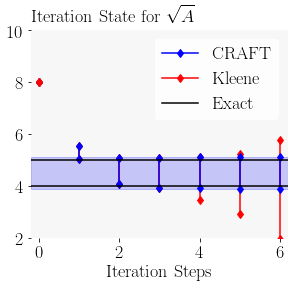

In [15]:
fig, ax = plt.subplots(figsize=(4.2,4))

marker = "d"

for i in range(min(len(ub_craft),len(ub_kleene))):
    if i>0:
        plt.plot([i,i],[lb_kleene[i], ub_kleene[i]],f"-{marker}", color="r", label='_nolegend_')
        plt.plot([i,i],[lb_craft[i], ub_craft[i]],f"-{marker}", color="b", label='_nolegend_')
    else:
        plt.plot([i,i],[lb_craft[i], ub_craft[i]],f"-{marker}", color="b")
        plt.plot([i,i],[lb_kleene[i], ub_kleene[i]],f"-{marker}", color="r")

# plt.fill([-0.2, len(ub_craft)+0.2, len(ub_craft)+0.2, -0.2], [lb_kleene[-1],lb_kleene[-1],ub_kleene[-1],ub_kleene[-1]], color="r", alpha=0.15)
plt.fill([-0.2, len(ub_craft)+0.2, len(ub_craft)+0.2, -0.2], [lb_craft[-1],lb_craft[-1],ub_craft[-1],ub_craft[-1]], color="b", alpha=0.2)
plt.plot([-0.2, len(ub_craft)+0.2], [lb_e[-1],lb_e[-1]], color="k")
plt.plot([len(ub_craft)+0.2, -0.2], [ub_e[-1],ub_e[-1]], color="k")


plt.ylabel(r"Iteration State for $\sqrt{A}$",rotation=0 , fontsize=fontsize, ha="left")
ax.yaxis.set_label_coords(0.0, 1.03)
plt.xlabel("Iteration Steps", fontsize=fontsize)
plt.xlim([-0.2,6+0.2])
plt.xticks(np.arange(0,6.1,2))
plt.ylim([2,10])
plt.yticks(np.arange(2.,10.01,2))
plt.legend(["CRAFT", "Kleene", "Exact"], frameon=True, edgecolor="none", fontsize=fontsize)

ax.set_facecolor( (0.97, 0.97, 0.97) )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.tight_layout()

## Newton method

In [16]:
def step(x, A):
    x = x * (- 0.5 * A * x*x + 1.5)
    return x

In [17]:
A_rng = [16, 20]
x0 = 2**(-3)
eps = 1e-6

In [18]:
A = A_rng[0]
x = x0

lb_e = [1/x0]

for i in range(50):
    x = step(x, A)
    lb_e.append(1/x)

A = A_rng[1]
x = x0

ub_e = [x0]

for i in range(50):
    x = step(x, A)
    ub_e.append(1/x)

In [19]:
### CRAFT for Householder
torch.set_printoptions(precision=8)

x = HybridZonotope.construct_from_bounds(torch.tensor([[x0]]), torch.tensor([[x0]]), domain='zono', dtype=dtype)
A = HybridZonotope.construct_from_bounds(torch.tensor([[A_rng[0]]]), torch.tensor([[A_rng[1]]]), domain='zono', dtype=dtype)

lbs, ubs = [1/x.concretize()[0].item()], [1/x.concretize()[1].item()]

print(f"Input range [{A.concretize()[0].item():.2f}, {A.concretize()[1].item():.2f}]")

print(f"Init range [{1/x.concretize()[0].item():.2f}, {1/x.concretize()[1].item():.2f}]")


for i in range(50):
    xnew = step(x, A)
    lb, ub = xnew.concretize()
    root = x.concretize_into_box()#.reciprocal()
    lbs.append(1/xnew.concretize()[0].item())
    ubs.append(1/xnew.concretize()[1].item())
    root_new = xnew.concretize_into_box()#.reciprocal()
    print(f"root{i+1}", xnew.concretize_into_box().reciprocal().concretize())
    cont, _ = root.can_contain(root_new)
    if cont:
        print(x.concretize())
        print(xnew.concretize())
        print(f"x{i+1} in x{i} -> break" )
        break
    x = xnew

lb_craft = lbs
ub_craft = ubs

Input range [16.00, 20.00]
Init range [8.00, 8.00]
root1 (tensor([[5.81818199]]), tensor([[5.95348835]]))
root2 (tensor([[4.60418701]]), tensor([[4.89206886]]))
root3 (tensor([[4.10120964]]), tensor([[4.53313351]]))
root4 (tensor([[4.00281715]]), tensor([[4.49335670]]))
root5 (tensor([[3.99832678]]), tensor([[4.49335241]]))
root6 (tensor([[3.99812579]]), tensor([[4.49340343]]))
root7 (tensor([[3.99810195]]), tensor([[4.49340630]]))
root8 (tensor([[3.99809933]]), tensor([[4.49340630]]))
root9 (tensor([[3.99809957]]), tensor([[4.49340725]]))
root10 (tensor([[3.99809957]]), tensor([[4.49340725]]))
(tensor([[0.22254830]], dtype=torch.float64), tensor([[0.25011887]], dtype=torch.float64))
(tensor([[0.22254830]], dtype=torch.float64), tensor([[0.25011887]], dtype=torch.float64))
x10 in x9 -> break


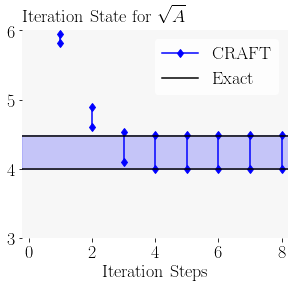

In [20]:
fig, ax = plt.subplots(figsize=(4.2,4))

marker = "d"

for i in range(len(ub_craft)):
    if i>0:
        plt.plot([i,i],[lb_craft[i], ub_craft[i]],f"-{marker}", color="b", label='_nolegend_')
    else:
        plt.plot([i,i],[lb_craft[i], ub_craft[i]],f"-{marker}", color="b")

plt.fill([-0.2, len(ub_craft)+0.2, len(ub_craft)+0.2, -0.2], [lb_craft[-1],lb_craft[-1],ub_craft[-1],ub_craft[-1]], color="b", alpha=0.2)
plt.plot([-0.2, len(ub_craft)+0.2], [lb_e[-1],lb_e[-1]], color="k")
plt.plot([len(ub_craft)+0.2, -0.2], [ub_e[-1],ub_e[-1]], color="k")


plt.ylabel(r"Iteration State for $\sqrt{A}$",rotation=0 , fontsize=fontsize, ha="left")
ax.yaxis.set_label_coords(0.0, 1.03)
plt.xlabel("Iteration Steps", fontsize=fontsize)
plt.xlim([-0.2,8+0.2])
plt.xticks(np.arange(0,10,2))
plt.ylim([3,6])
plt.yticks(np.arange(3.,6.01,1))
plt.legend(["CRAFT", "Exact"], frameon=True, edgecolor="none", fontsize=fontsize)

ax.set_facecolor( (0.97, 0.97, 0.97) )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.tight_layout()